### NOTEBOOK 1
# Variational Auto Encoder
### Warning:
The model used in the actual analysis has the same architecture as the one shown here but has been trained on more epochs and with more data using Google-Colab

Import necessary packages

In [7]:
from glob import glob
import numpy as np
import numpy.random as npr
import sklearn
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import linalg as la
from keras import regularizers
from keras import backend as K
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Input,
    Flatten,
    Dense,
    Lambda,
    Reshape,
)

2023-06-08 16:49:13.541156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Define core features of the dataset

In [8]:
dim = 2
numpart = 30
latent_dim = 40
box_size = 10

Import the training data and add gamma labels

In [12]:
dump_dir = "./mc-sampling/good-runs/"
# read all position files in chosen directory
files = glob(dump_dir + "gamma*_10000_*_x.txt")
# sort files by gamma value
files = np.array(files)[np.argsort([f.split("_")[1] for f in files])]
gamma = np.sort([f.split("_")[1] for f in files]).astype(float)

num_gammas = files.size
arrays = [np.loadtxt(f) for f in files]

# combine data + reshape, and assign labels to different datasets
data = np.vstack(arrays)
vcs = data.reshape((-1, numpart, dim)) / (box_size * np.sqrt(dim))
labels = np.hstack([[i] * len(a) for i, a in enumerate(arrays)])

### Manipulate data
Sort points by distance from origin

In [13]:
sort_idx = np.argsort(vcs[:, :, 0] ** 2 + vcs[:, :, 1] ** 2)
sorted_vcs = np.array(
    [sample[sort_idx[i]] for i, sample in enumerate(vcs)]
)

Compute distance matrix for each configuration

In [14]:
dm = np.array([squareform(pdist(sample)) for sample in sorted_vcs])

Split in training and test set

In [15]:
train_perc = 0.8

m = sorted_vcs.shape[0]  # total number of samples
m_training = int(m * train_perc)  # samples in the training set
m_test = m - m_training  # samples in the test set

while True:
    permutation = np.random.permutation(m)

    sorted_vcs = sorted_vcs[permutation]
    labels = labels[permutation]
    dm = dm[permutation]

    trainset_conf = sorted_vcs[:m_training]
    testset_conf = sorted_vcs[m_training:]

    trainset_mat = dm[:m_training]
    testset_mat = dm[m_training:]

    counts = [
        np.count_nonzero(labels[:m_training] == i)
        for i in range(num_gammas)
    ]

    # if each label is represented by at least half of
    # training set size / number of files
    # we're good and we can stop permutating
    if all(c > int(m_training / (2 * num_gammas)) for c in counts):
        break

print("Samples in training set: ", trainset_conf.shape[0])
print("Samples in test set: ", testset_conf.shape[0])

Samples in training set:  32000
Samples in test set:  8000


## Variational Auto Encoder
### Sampling Class

In [2]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

NameError: name 'layers' is not defined

### Encoder

In [3]:
encoder_inputs = keras.Input(shape=(numpart, numpart, 1))
x = Conv2D(60, 3, padding="same", activation="relu")(encoder_inputs)
x = Conv2D(50, 3, padding="same", activation="relu")(x)
conv_shape = K.int_shape(x)  # Shape of conv to be provided to decoder
x = Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(
    encoder_inputs, [z_mean, z_log_var, z], name="encoder"
)
encoder.summary()

NameError: name 'keras' is not defined

### Decoder

In [ ]:
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
x = Dense(
    conv_shape[1] * conv_shape[2] * conv_shape[3], activation="relu"
)(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(50, 3, padding="same", activation="relu")(x)
x = Conv2DTranspose(60, 3, padding="same", activation="relu")(x)
decoder_outputs = Conv2DTranspose(
    1, 3, padding="same", activation="sigmoid", name="decoder_output"
)(x)

decoder = keras.Model(decoder_input, decoder_outputs, name="decoder")
decoder.summary()


### VAE Class

In [42]:
reg_lambda = 0.00035


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Extract dimensions excluding the first 'None' dimension
            size = reconstruction.shape[1:]

            # Reshape data to match decoder output shape
            data = tf.expand_dims(data, axis=-1)

            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + reg_lambda * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


### Train VAE

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))  # lower learning rate
fit = vae.fit(trainset_mat, epochs=10, batch_size=128, verbose=2)

In [4]:
plt.rcParams["font.size"] = 12
fig, AX = plt.subplots(1, 2, figsize=(14, 6.0))
ax = AX[0]
ax.plot(fit.history["loss"], label="MSE loss", c="#78226B")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
ax.legend()
ax = AX[1]
ax.plot(fit.history["kl_loss"], label="KL loss", c="#FDD50B")
ax.set_xlabel("Epoch")
ax.set_ylabel("KL loss")
ax.legend()

NameError: name 'plt' is not defined

### Save model for future use

In [6]:
'''tf.keras.models.save_model(vae.encoder, "saved_model/encoder")
tf.keras.models.save_model(vae.decoder, "saved_model/decoder")'''

'tf.keras.models.save_model(vae.encoder, "saved_model/encoder")\ntf.keras.models.save_model(vae.decoder, "saved_model/decoder")'

## Test Results

In [43]:
encoder = keras.models.load_model('./vae/saved_models/encoder')
decoder = keras.models.load_model('./vae/saved_models/decoder')

vae = VAE(encoder, decoder)

### Encoding and latent dimension
Encode the test set

In [45]:
encoded_test = np.array(vae.encoder.predict(testset_mat))

print(encoded_test.shape)

250/250 [==============================] - 4s 16ms/step
(3, 8000, 40)


Check clustering in latent space

In [46]:
def label_vis(vae, data, labels):
    # prediction
    z_mean, _, _ = vae.encoder.predict(data)

    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(z_mean)
    variance_ratio = pca.explained_variance_ratio_
    print(variance_ratio)

    # plot
    plt.figure(figsize=(5, 5))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

1250/1250 [==============================] - 23s 19ms/step
[0.04435531 0.04011992]


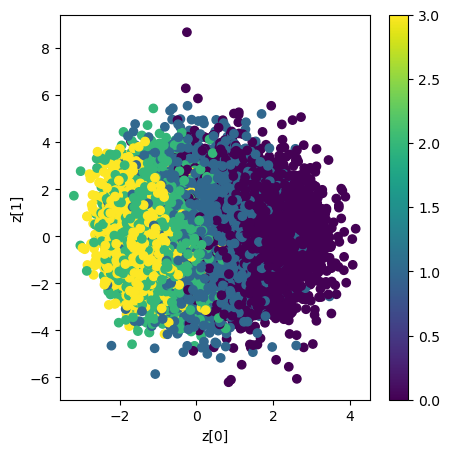

In [47]:
label_vis(vae, dm, labels)

### Decoding
Decode test set and compare to the original

In [48]:
decoded_test = np.array(decoder.predict(encoded_test[2, :, :])).reshape(-1, numpart, numpart)

print(decoded_test.shape)

250/250 [==============================] - 9s 35ms/step
(8000, 30, 30)


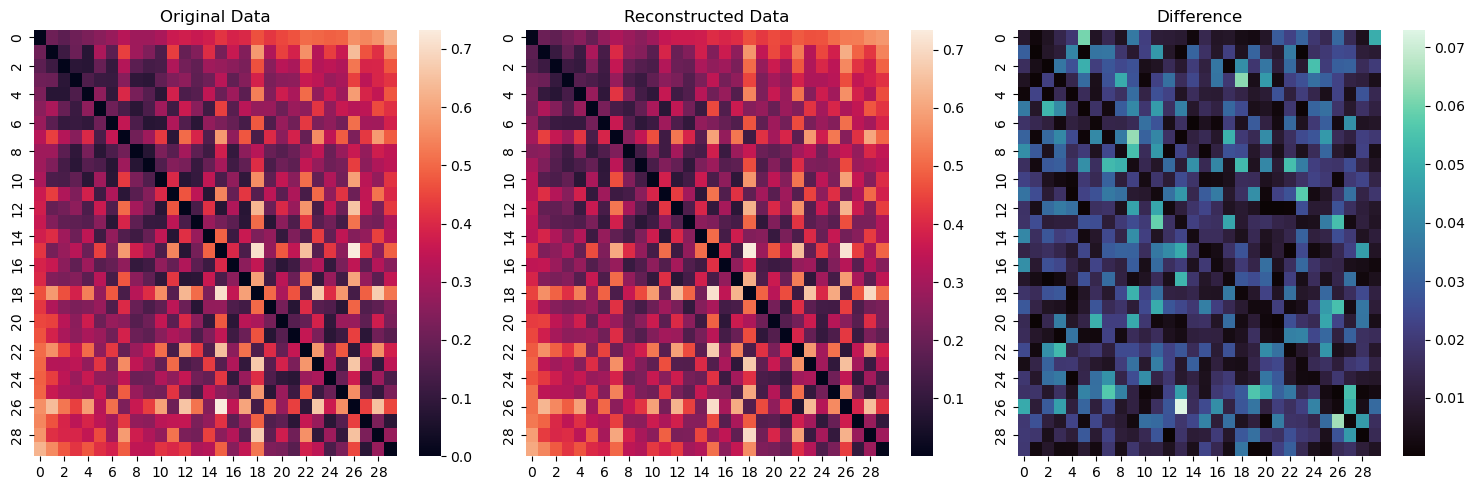

In [54]:
ind = 42
df = pd.DataFrame(testset_mat[ind])
df2 = pd.DataFrame(decoded_test[ind])
df3 = pd.DataFrame(abs(testset_mat[ind] - decoded_test[ind]))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(pd.DataFrame(df), ax=axs[0])
axs[0].set_title('Original Data')

sns.heatmap(pd.DataFrame(df2), ax=axs[1])
axs[1].set_title('Reconstructed Data')

sns.heatmap(pd.DataFrame(df3), cmap="mako", ax=axs[2])
axs[2].set_title('Difference')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Reconstruct Coordinates
Extract points from distance matrix

In [55]:
def gram_to_coordinates(distance_matrix):
    # Get the number of points
    n = distance_matrix.shape[0]

    # Compute the Gram matrix
    gram_matrix = -0.5 * (distance_matrix**2)

    # Center the Gram matrix
    gram_matrix_centered = (
        gram_matrix
        - np.mean(gram_matrix, axis=0)
        - np.mean(gram_matrix, axis=1)[:, np.newaxis]
        + np.mean(gram_matrix)
    )

    # Perform eigendecomposition of the centered Gram matrix
    eigenvalues, eigenvectors = np.linalg.eigh(gram_matrix_centered)

    # Sort eigenvalues and eigenvectors in descending order
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]

    # Extract the positive square root of eigenvalues
    sqrt_eigenvalues = np.sqrt(np.maximum(eigenvalues, 0))

    # Compute the coordinates of the points in 2D space
    coordinates = eigenvectors[:, :2] * sqrt_eigenvalues[:2]

    return coordinates

Example with one configuration of the original data

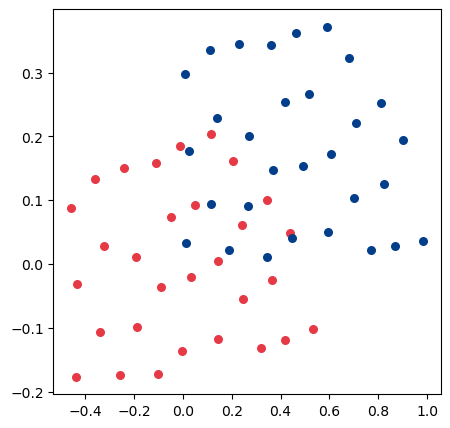

In [57]:
coordinates = gram_to_coordinates(testset_mat[1])

ind = 1
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    coordinates[:, 0] * l,
    coordinates[:, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
plt.show()

Shift and rotate to match original data as good as possible

In [58]:
def align_points(points1, points2):
    # Center the points by subtracting their means
    centered_points1 = points1 - np.mean(points1, axis=0)
    centered_points2 = points2 - np.mean(points2, axis=0)

    # Compute the covariance matrix
    covariance_matrix = centered_points2.T @ centered_points1

    # Perform singular value decomposition (SVD)
    U, _, Vt = np.linalg.svd(covariance_matrix)

    # Calculate the optimal rotation matrix
    rotation_matrix = Vt.T @ U.T

    # Calculate the optimal translation vector
    translation_vector = np.mean(points2, axis=0) - np.mean(
        points1 @ rotation_matrix, axis=0
    )

    # Transform points1 using the estimated rotation and translation
    transformed_points = points1 @ rotation_matrix + translation_vector

    return transformed_points

Example with previous configuration

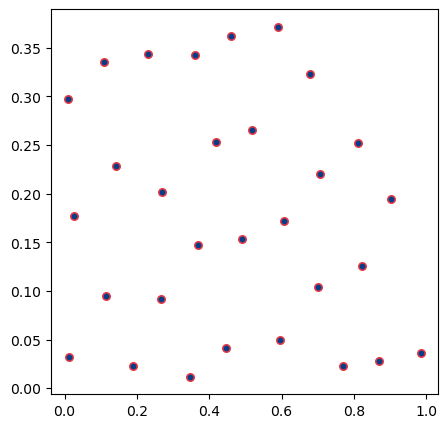

In [60]:
coordinates = align_points(coordinates, testset_conf[1])
ind = 1
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    coordinates[:, 0] * l,
    coordinates[:, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=10,
    c="#023e8a",
)
plt.show()

As we can see points are perfectly aligned

Apply to whole dataset and plot example

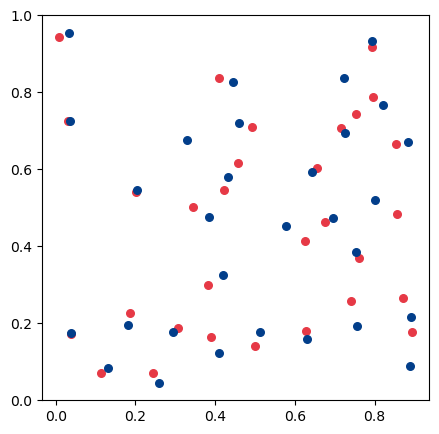

In [63]:
rec_test_dec = np.zeros((testset_conf.shape))

for i in range(0, len(rec_test_dec)):
    rec_test_dec[i] = align_points(
        gram_to_coordinates(decoded_test[i]), testset_conf[i]
    )
    
ind = 70
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
l = np.sqrt(2)
ax.scatter(
    rec_test_dec[ind, :, 0] * l,
    rec_test_dec[ind, :, 1] * l,
    s=30,
    c="#e63946",
)
ax.scatter(
    testset_conf[ind, :, 0] * l,
    testset_conf[ind, :, 1] * l,
    s=30,
    c="#023e8a",
)
plt.show()

### See you in the next notebook